In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

from nltk.sentiment.vader import SentimentIntensityAnalyzer

warnings.filterwarnings('ignore')

# USING SELENIUM TO SCRAPE IMPOSSIBLE BURGER TWEETS
<a href="https://www.selenium.dev/">Selenium</a> is a package used to automate web browsing. To run this yourself you'll have to download the Selenium WebDriver and set the ```path``` variable to where it is located on your computer. I have found that Google Chrome is much faster than FireFox and therefore recommend Chrome.

The problem using Selenium to scrape tweets is Twitter makes their HTML tags incredibly obfuscated. The following is an example of the class names used to store a single tweet:
<img src="https://i.ibb.co/kMWwPWr/twitter-tags-hard.jpg" alt="twitter-tags-hard" border="0">

To get around this, I download a Chrome extension that displays the old twitter layout. With this I'm able to get the tweets by simply looking at class name ```"content"```:
<img src="https://i.ibb.co/R2wb5ZV/twitter-easy-tags.jpg" alt="twitter-easy-tags" border="0">

So I open Chrome with Selenium, download the Chrome extension, search for the desired results, then I scroll for a long time to the bottom of the search results in order to load and save all the tweets!

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
import time

# Setting path and opening browser
path = r'C:\\Users\\lukef\\AppData\\Local\\BrowserDriver\chromedriver.exe'
driver = webdriver.Chrome(executable_path = path)#, options=opts)

# Navigating to old twitter layout extension
site = 'https://chrome.google.com/webstore/detail/old-twitter-layout/jjldkokjmjdnlnifmehbljdafklejeha/related?hl=en'
driver.get(site)
time.sleep(2)

# Building actions class to interact with the website
actions = ActionChains(driver)

# Click download button
actions.move_to_element(driver.find_element_by_class_name('g-c-Hf'))
actions.click().perform()

# Now you must click on download!!!
time.sleep(5)

# Navigating to twitter search
site = 'https://twitter.com/search?l=en&q=%22impossible%20burger%22%20-Reply&src=typd'
driver.get(site)
time.sleep(2)

# Scroll down to load more tweets
body = driver.find_element_by_css_selector('body')
start = time.time()
while time.time() - start < 60*15:
    body.send_keys(Keys.PAGE_DOWN)

# Get tweets
twitter_elms = driver.find_elements_by_class_name("content")
imp = [twitter_elms[i].text for i in range(len(twitter_elms))]

# Closing browser
driver.close()

# SCRAPING BEYOND BURGER TWEETS
The following works the same way as above except searches for Beyond Burger tweets. I probably didn't need to close the browser and start over but that's a quick fix I'll update later.

In [4]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
import time

# Setting path and opening browser
path = r'C:\\Users\\lukef\\AppData\\Local\\BrowserDriver\chromedriver.exe'
driver = webdriver.Chrome(executable_path = path)#, options=opts)

# Navigating to old twitter layout extension
site = 'https://chrome.google.com/webstore/detail/old-twitter-layout/jjldkokjmjdnlnifmehbljdafklejeha/related?hl=en'
driver.get(site)
time.sleep(2)

# Building actions class to interact with the website
actions = ActionChains(driver)

# Click download button
actions.move_to_element(driver.find_element_by_class_name('g-c-Hf'))
actions.click().perform()

# Now you must click on download!!!
time.sleep(5)

# Navigating to twitter search
site = 'https://twitter.com/search?l=en&q=%22beyond%20burger%22%20-Reply&src=typd'
driver.get(site)
time.sleep(2)

# Scroll down to load more tweets
body = driver.find_element_by_css_selector('body')
start = time.time()
while time.time() - start < 60*15:
    body.send_keys(Keys.PAGE_DOWN)

# Get tweets
twitter_elms2 = driver.find_elements_by_class_name("content")
bey = [twitter_elms2[i].text for i in range(len(twitter_elms2))]

# Closing browser
driver.close()

# CONVERTING TO PANDAS DATAFRAME
Attaching a column called ```impossible``` with value 1 for impossible burger tweets and value 0 for beyond burger tweets.


In [123]:
df1= pd.DataFrame({'raw_text':imp})
df1['impossible'] = 1

df2 = pd.DataFrame({'raw_text':bey})
df2['impossible'] = 0

df = pd.concat([df1,df2])

# Saving the 'uncleaned' dataframe to a csv file
df.to_csv('ImpossibleVsBeyond.csv', index = False)
df.reset_index(drop = True, inplace = True)

df.head()

,raw_text,impossible
0,rachelkonrad\n @rachelkonrad\nFeb 26\nMore\nTh...,1
1,Eric\n @MageTheBagel\n26m\n26 minutes ago\nMor...,1
2,♫ 𝗧𝗵𝗲 𝗥 𝗢 𝗬 𝗔 𝗟 𝗘 𝗗 𝗜 𝗧 𝗜 𝗢 𝗡. ♫\n @FateOfRebe...,1
3,Plant Test Kitchen\n @AmyWozny\nFeb 29\nMore\n...,1
4,Pear Street Bistro\n @PearStreet\n25m\n25 minu...,1


In [5]:
df = pd.read_csv('ImpossibleVsBeyond.csv')

# REMOVING DUPLICATES
Many of the tweets contain both Beyond Burger and Impossible Burger in their text. These then all show up twice in our dataset. I'm removing them all since my goal is to compare the average sentiment of Impossible *versus* Beyond.

In [17]:
df = df[~df['raw_text'].duplicated(keep=False)]

# EXTRACTING TIME/DATE
We can see that the time and date is always sandwiched as so:  
&ensp;&ensp;```\n @username\n(TIME/DATE)\n```    
So I'll use a regular expression to capture just that.

In [18]:
regex = r'\n @.*?\n(.*?)\n'
df['date'] = df['raw_text'].str.extract(regex)
df

,raw_text,impossible,date
0,rachelkonrad\n @rachelkonrad\nFeb 26\nMore\nTh...,1,Feb 26
1,Eric\n @MageTheBagel\n26m\n26 minutes ago\nMor...,1,26m
2,♫ 𝗧𝗵𝗲 𝗥 𝗢 𝗬 𝗔 𝗟 𝗘 𝗗 𝗜 𝗧 𝗜 𝗢 𝗡. ♫\n @FateOfRebe...,1,2h
3,Plant Test Kitchen\n @AmyWozny\nFeb 29\nMore\n...,1,Feb 29
4,Pear Street Bistro\n @PearStreet\n25m\n25 minu...,1,25m
...,...,...,...
2766,Cameron Bibb\n @Cameron_Bibb\n31 Mar 2010\nMor...,0,31 Mar 2010
2767,Jasmine Carosfield\n @JasmineGirl87\n3 Feb 201...,0,3 Feb 2010
2768,audree.\n @qrownassaud\n19 Jan 2010\nMore\n@kY...,0,19 Jan 2010
2769,David Harlan\n @smallerfish\n23 Oct 2009\nMore...,0,23 Oct 2009


# FILLING IN MISSING VALUES
Two values weren't caught by the regular expression, since it was only 2 I'm simply filling in the values manually.

In [19]:
df[df['date'].isna()]

,raw_text,impossible,date
1970,@urbansadfitters\nFeb 23\nMore\njust ate a do...,0,NaN
2010,@FlowerElsat\nFeb 22\nMore\ni had a lightlife...,0,NaN


In [20]:
df['date'][1970] = '23 Feb 2020'
df['date'][2010] = '22 Feb 2020'

# FIXING INCONSISTENT DATE FORMATTING
Posts from today show up as ```4h``` or ```2m```, posts from this year appear as ```Month Day``` and beyond that is ```Day Month Year```. I'll switch everything to ```Day Month Year```.

Thankfully none of the month abbreviations contain lower case m's nor lower case h's so dates containing those lowercase letters can all be safely replaced with today's date (2 March 2020).

In [21]:
df.loc[df[df['date'].str.contains(r'h|m')].index, 'date'] = '2 Mar 2020'

Now, the posts from this year don't contain the year in their date so by filtering for posts that don't have 4 digits in a row (```\d{4}```) we can get all the posts from this year and extract their month and day to rearrange to day month year.

In [22]:
this_year = df[~df['date'].str.contains(r'\d{4}')]
this_year.head()

,raw_text,impossible,date
0,rachelkonrad\n @rachelkonrad\nFeb 26\nMore\nTh...,1,Feb 26
3,Plant Test Kitchen\n @AmyWozny\nFeb 29\nMore\n...,1,Feb 29
8,Fr. Marlon Mendieta\n @FrMarlonM\nFeb 27\nMore...,1,Feb 27
9,Fr. Josh Miller\n @FrJoshMiller\nFeb 28\nMore\...,1,Feb 28
10,GMO Free USA\n @GMOFreeUSA\nFeb 24\nMore\nIB m...,1,Feb 24


In [23]:
date_components = this_year['date'].str.extract(r'([A-Za-z]*)\s(\d{1,2})')
date_components.head()

,0,1
0,Feb,26
3,Feb,29
8,Feb,27
9,Feb,28
10,Feb,24


In [24]:
fixed_dates = date_components[1] + ' ' + date_components[0] + ' 2020'
df.loc[fixed_dates.index, 'date'] = fixed_dates

Now converting to Pandas datetime format. One of the values comes up missing, its raw text is:  

    ```"Umbral Reaver :) | Penumbra ·:)\n @UmbralReaver\n1d\n1 day ago\nMore\nReplying to @UmbralReaver @anarchomastia\nThis is from my old 'first dose of progesterone' comic, later edited to the 'impossible burger' comic.\n\nI was not expecting to find another good use for it.\nReply\nRetweet\n3\nLike\n108"```
So apparently this was the only tweet with a time listed as a day ago in this dataset. In the future it will be smart then to use ```(h|m|d)``` to find current dates. For now I'll just fill it in manually.


In [25]:
df['date'] = pd.to_datetime(df['date'])

# Filling in the one missing value
df.loc[df['date'].isna(), 'date'] = pd.to_datetime('2 March 2020')

df

,raw_text,impossible,date
0,rachelkonrad\n @rachelkonrad\nFeb 26\nMore\nTh...,1,2020-02-26
1,Eric\n @MageTheBagel\n26m\n26 minutes ago\nMor...,1,2020-03-02
2,♫ 𝗧𝗵𝗲 𝗥 𝗢 𝗬 𝗔 𝗟 𝗘 𝗗 𝗜 𝗧 𝗜 𝗢 𝗡. ♫\n @FateOfRebe...,1,2020-03-02
3,Plant Test Kitchen\n @AmyWozny\nFeb 29\nMore\n...,1,2020-02-29
4,Pear Street Bistro\n @PearStreet\n25m\n25 minu...,1,2020-03-02
...,...,...,...
2766,Cameron Bibb\n @Cameron_Bibb\n31 Mar 2010\nMor...,0,2010-03-31
2767,Jasmine Carosfield\n @JasmineGirl87\n3 Feb 201...,0,2010-02-03
2768,audree.\n @qrownassaud\n19 Jan 2010\nMore\n@kY...,0,2010-01-19
2769,David Harlan\n @smallerfish\n23 Oct 2009\nMore...,0,2009-10-23


# FILTERING OUT-DATED TWEETS
The Impossible Burger was launched in July 2016 so only keeping tweets from then onwards.  
Similarly the Beyond Burger was released in February 2015 so we'll filter for after that date.

In [26]:
impossible_dates = (df['date']>pd.Timestamp(2016,7,1)) & (df['impossible']==1)
beyond_dates = (df['date']>pd.Timestamp(2015,2,1)) & (df['impossible']==0)

df = df[impossible_dates | beyond_dates]
df

,raw_text,impossible,date
0,rachelkonrad\n @rachelkonrad\nFeb 26\nMore\nTh...,1,2020-02-26
1,Eric\n @MageTheBagel\n26m\n26 minutes ago\nMor...,1,2020-03-02
2,♫ 𝗧𝗵𝗲 𝗥 𝗢 𝗬 𝗔 𝗟 𝗘 𝗗 𝗜 𝗧 𝗜 𝗢 𝗡. ♫\n @FateOfRebe...,1,2020-03-02
3,Plant Test Kitchen\n @AmyWozny\nFeb 29\nMore\n...,1,2020-02-29
4,Pear Street Bistro\n @PearStreet\n25m\n25 minu...,1,2020-03-02
...,...,...,...
2721,Hollie Strano\nVerified account\n @holliesmile...,0,2015-07-29
2722,Derp Dragon\n @psydraggy\n22 Jun 2015\nMore\nR...,0,2015-06-22
2723,Elevation Burger\n @EBHYATTSVILLE\n1 Jun 2015\...,0,2015-06-01
2724,Kit Chapman MBE\n @Kit_Chapman\n14 Apr 2015\nM...,0,2015-04-14


# EXTRACTING AND CLEANING TWEET TEXT
An example of the raw text we have is:

    ```rachelkonrad\n @rachelkonrad\nFeb 26\nMore\nThe @chicagotribune says some Christian religious leaders consider #impossibleburger unacceptable during Lent because it's so close to animal meat that it's just cheating. This is perhaps the greatest product endorsement in the last 6,000 years.\nReply\n20\nRetweet\n71\nLike\n260```
The actual text comes in-between ```\nMore\n``` and ```\nReply``` so we'll try extracting between there.

In [27]:
df['text'] = df['raw_text'].str.extract(r'\nMore\n([\s\S]*?)\nReply')
df.head()

,raw_text,impossible,date,text
0,rachelkonrad\n @rachelkonrad\nFeb 26\nMore\nTh...,1,2020-02-26,The @chicagotribune says some Christian religi...
1,Eric\n @MageTheBagel\n26m\n26 minutes ago\nMor...,1,2020-03-02,Impossible burger? Call it mean't
2,♫ 𝗧𝗵𝗲 𝗥 𝗢 𝗬 𝗔 𝗟 𝗘 𝗗 𝗜 𝗧 𝗜 𝗢 𝗡. ♫\n @FateOfRebe...,1,2020-03-02,♫ 𝗧𝗵𝗲 𝗥 𝗢 𝗬 𝗔 𝗟 𝗘 𝗗 𝗜 𝗧 𝗜 𝗢 𝗡. ♫ Retweeted 𝓣𝓸𝓿...
3,Plant Test Kitchen\n @AmyWozny\nFeb 29\nMore\n...,1,2020-02-29,What's your favorite vegan cheese? I'm really ...
4,Pear Street Bistro\n @PearStreet\n25m\n25 minu...,1,2020-03-02,IMPOSSIBLE BURGER SLIDERS with Provolone chees...


This looks good but the retweets still have a lot of junk in them. For the time being I'm just going to choose to extract what the retweeter added and ignore the base tweet as they may have different sentiments. Some other methodology could be used in the future.

In [28]:
regex = 'Retweeted[\s\S]*?\n([\s\S]*)\n[\s\S]*added,'

indices_matches = df[df['text'].str.contains(regex)].index
df.loc[indices_matches, 'text'] = df.loc[indices_matches, 'text'].str.extract(regex)[0]

df.head()

,raw_text,impossible,date,text
0,rachelkonrad\n @rachelkonrad\nFeb 26\nMore\nTh...,1,2020-02-26,The @chicagotribune says some Christian religi...
1,Eric\n @MageTheBagel\n26m\n26 minutes ago\nMor...,1,2020-03-02,Impossible burger? Call it mean't
2,♫ 𝗧𝗵𝗲 𝗥 𝗢 𝗬 𝗔 𝗟 𝗘 𝗗 𝗜 𝗧 𝗜 𝗢 𝗡. ♫\n @FateOfRebe...,1,2020-03-02,""" I do not wish to eat that meat that you dish..."
3,Plant Test Kitchen\n @AmyWozny\nFeb 29\nMore\n...,1,2020-02-29,What's your favorite vegan cheese? I'm really ...
4,Pear Street Bistro\n @PearStreet\n25m\n25 minu...,1,2020-03-02,IMPOSSIBLE BURGER SLIDERS with Provolone chees...


Finally we'll clean out the ```Replying to @user1 @user2\n``` part of the reply tweets.

In [29]:
regex = r'Replying to.*?\n(.*)'

replies_indices = df[df['text'].str.contains(r'Replying to')].index
df.loc[replies_indices, 'text'] = df.loc[replies_indices,'text'].str.extract(regex)[0]

df.loc[replies_indices, 'text'].head()

15     This is from my old 'first dose of progesteron...
18     They could afford to rent an organ at $2500 fo...
28     It wasn't just the food. She got him an Imposs...
94     Heh, she could sue him for the $6 bucks she sp...
124    State boot lickers eating impossible burger's....
Name: text, dtype: object

# GETTING SENTIMENT OF EACH TWEET
I'll be using the vader sentiment analyzer. Before you can initialize the analyzer you must download the lexicon file, you can do so by running:
```Python 
import nltk
nltk.download('vader_lexicon')```

In [30]:
analyzer = SentimentIntensityAnalyzer()

In [31]:
def get_sentiment(row):
    return analyzer.polarity_scores(row['text'])['compound']

df['sentiment'] = df.apply(get_sentiment, axis = 1)
df.head()

,raw_text,impossible,date,text,sentiment
0,rachelkonrad\n @rachelkonrad\nFeb 26\nMore\nTh...,1,2020-02-26,The @chicagotribune says some Christian religi...,-0.0258
1,Eric\n @MageTheBagel\n26m\n26 minutes ago\nMor...,1,2020-03-02,Impossible burger? Call it mean't,0.0000
2,♫ 𝗧𝗵𝗲 𝗥 𝗢 𝗬 𝗔 𝗟 𝗘 𝗗 𝗜 𝗧 𝗜 𝗢 𝗡. ♫\n @FateOfRebe...,1,2020-03-02,""" I do not wish to eat that meat that you dish...",-0.3089
3,Plant Test Kitchen\n @AmyWozny\nFeb 29\nMore\n...,1,2020-02-29,What's your favorite vegan cheese? I'm really ...,0.6486
4,Pear Street Bistro\n @PearStreet\n25m\n25 minu...,1,2020-03-02,IMPOSSIBLE BURGER SLIDERS with Provolone chees...,0.0000


# ESTIMATED PDF OF BEYOND AND IMPOSSIBLE SENTIMENT
We can see the Beyond Burger distribution is shifted a bit to the right of the Impossible Burger distribution, indicating that Beyond Burger tweets appear to be at least slightly more positive.

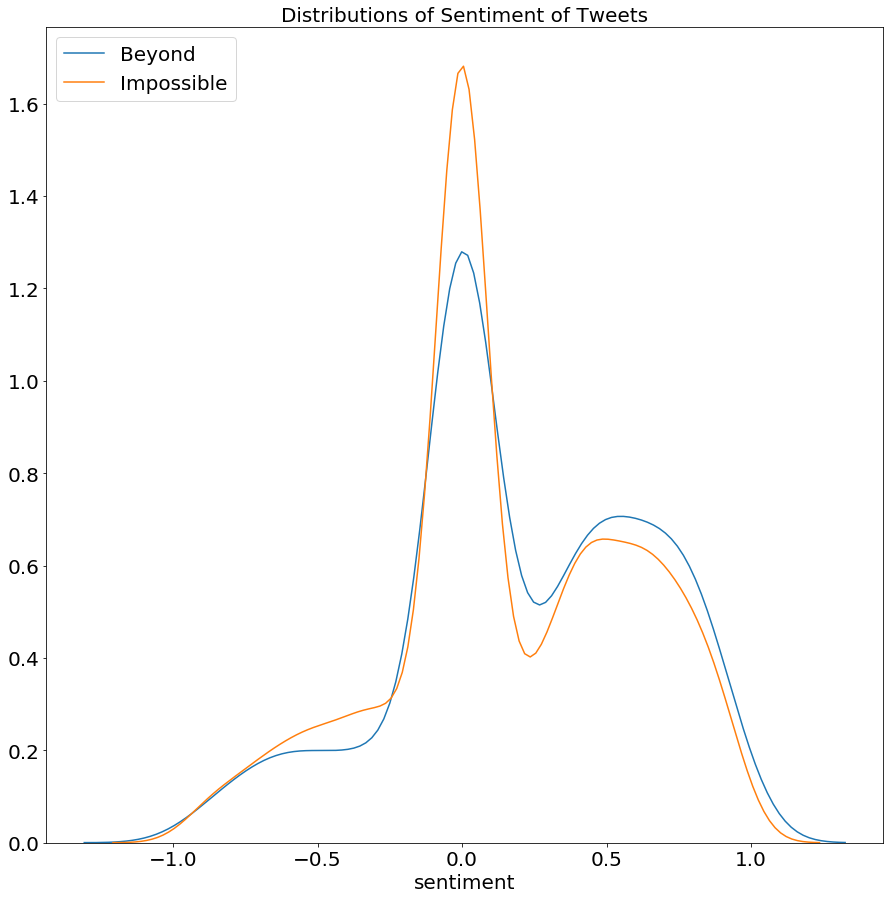

In [57]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)

sns.distplot(df[df['impossible']==0]['sentiment'], kde=True, hist=False,
             label="Beyond", ax=ax);
sns.distplot(df[df['impossible']==1]['sentiment'], kde=True, hist=False, 
             label="Impossible", ax=ax);

ax.set_title('Distributions of Sentiment of Tweets')

# Increasing size of text and ticks
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax.legend(loc=2,prop={'size':20});

# BOXPLOT OF BEYOND VS IMPOSSIBLE SENTIMENT

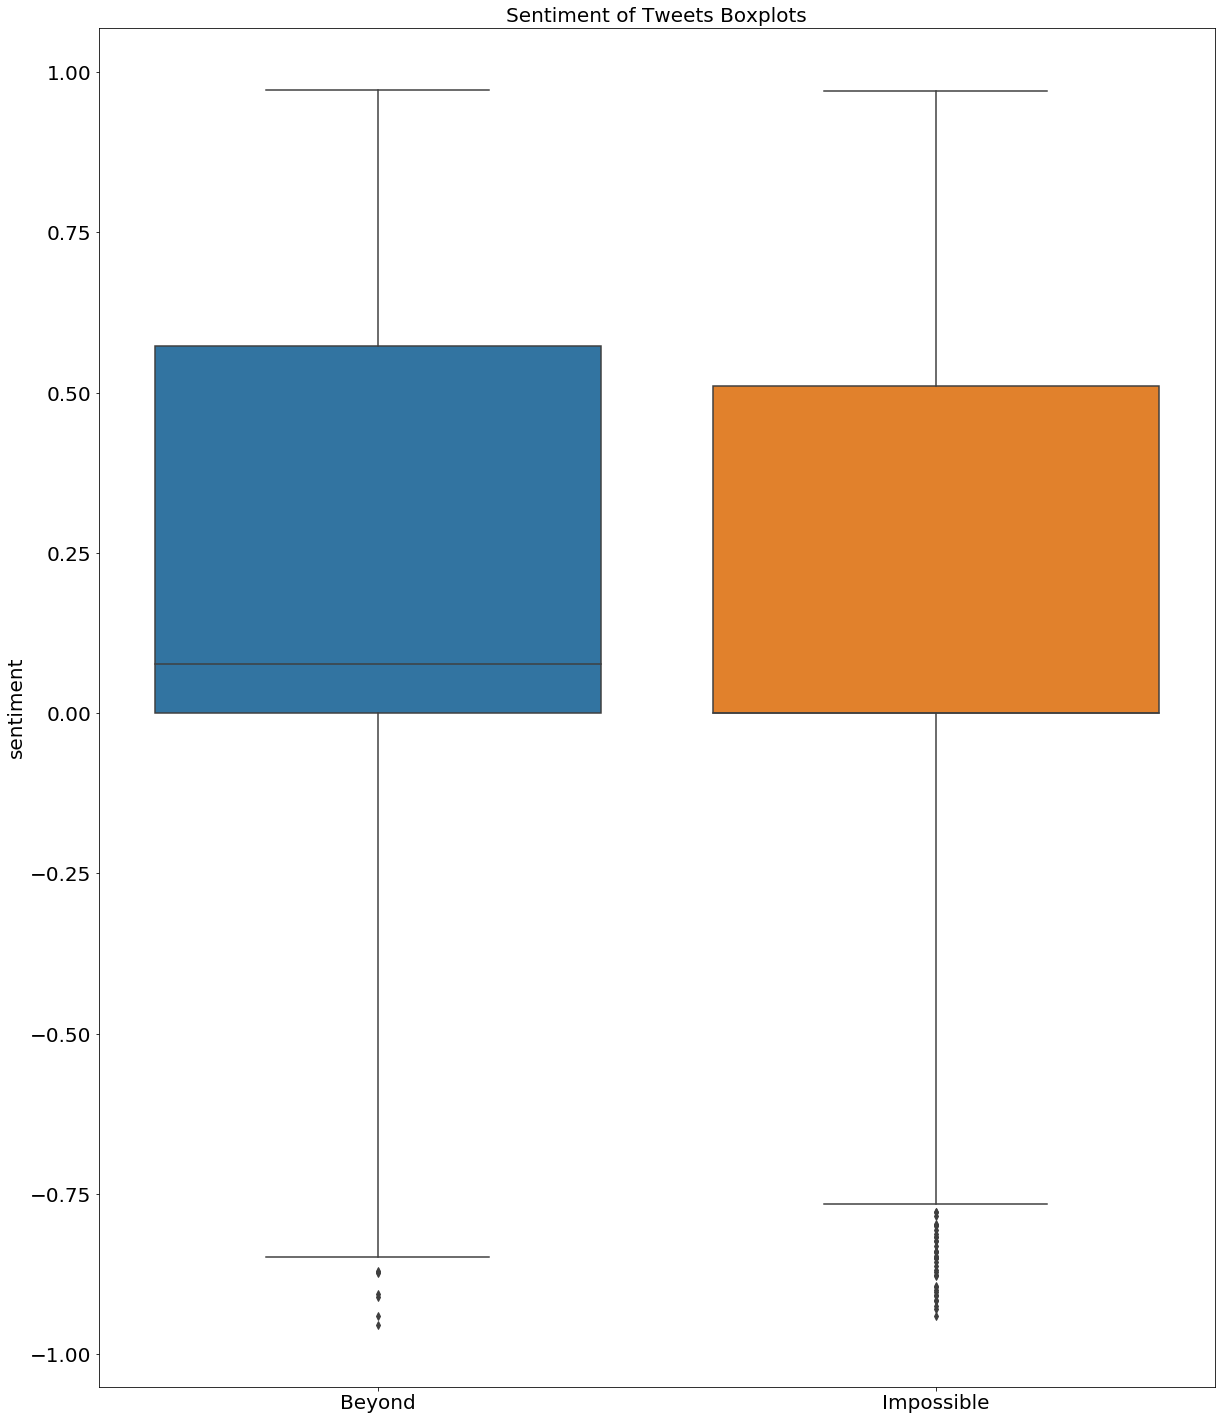

In [75]:
fig = plt.figure(figsize=(20,25))
ax = fig.add_subplot(111)

sns.boxplot(x='impossible', y='sentiment', data=df, ax=ax);

# Labeling Plot
ax.set_xticklabels(['Beyond','Impossible']);
ax.set_title('Sentiment of Tweets Boxplots');
ax.xaxis.label.set_visible(False)

# Increasing size of text and ticks
for item in ([ax.title, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

# REGRESSION COMPARING SENTIMENTS
In the regression below we see that the average sentiment of tweets containing impossible burger is about 0.0494 units lower than beyond burger tweets. This is a pretty small difference, as the standard deviation of the sentiment column is about 0.426, hence the difference is roughly a tenth of a standard deviation. Nonetheless, the difference is statistically significant at the 1% level.

In [34]:
import statsmodels.api as sm

df['const'] = 1
reg = sm.OLS(endog=df['sentiment'], exog=df[['impossible','const']])
results = reg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     7.501
Date:                Fri, 06 Mar 2020   Prob (F-statistic):            0.00621
Time:                        11:21:44   Log-Likelihood:                -1486.2
No. Observations:                2630   AIC:                             2976.
Df Residuals:                    2628   BIC:                             2988.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
impossible    -0.0494      0.018     -2.739      0.0

# REGRESSION COMPARING SENTIMENT BY YEAR
From 2016 to 2018 there's far less data so the estimates of differences in average sentiments varies quite a bit and none are significant at traditional confidence levels. However, 2019 and 2020 both estimate a lower average sentiment for the Impossible Burger tweets and these are both significant at the 5% level. 

In [37]:
df['year'] = df['date'].dt.year

for i in range(2016,2021):
    reg = sm.OLS(endog=df[df['year']==i]['sentiment'], exog=df[df['year']==i][['impossible','const']])
    results = reg.fit()
    print('Year: ', i, '\n', results.summary(), '\n\n')

Year:  2016 
                             OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.2309
Date:                Fri, 06 Mar 2020   Prob (F-statistic):              0.632
Time:                        11:23:18   Log-Likelihood:                -27.482
No. Observations:                  91   AIC:                             58.96
Df Residuals:                      89   BIC:                             63.99
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
impossible     0.0361      0.075      

# BOXPLOTS BY YEAR

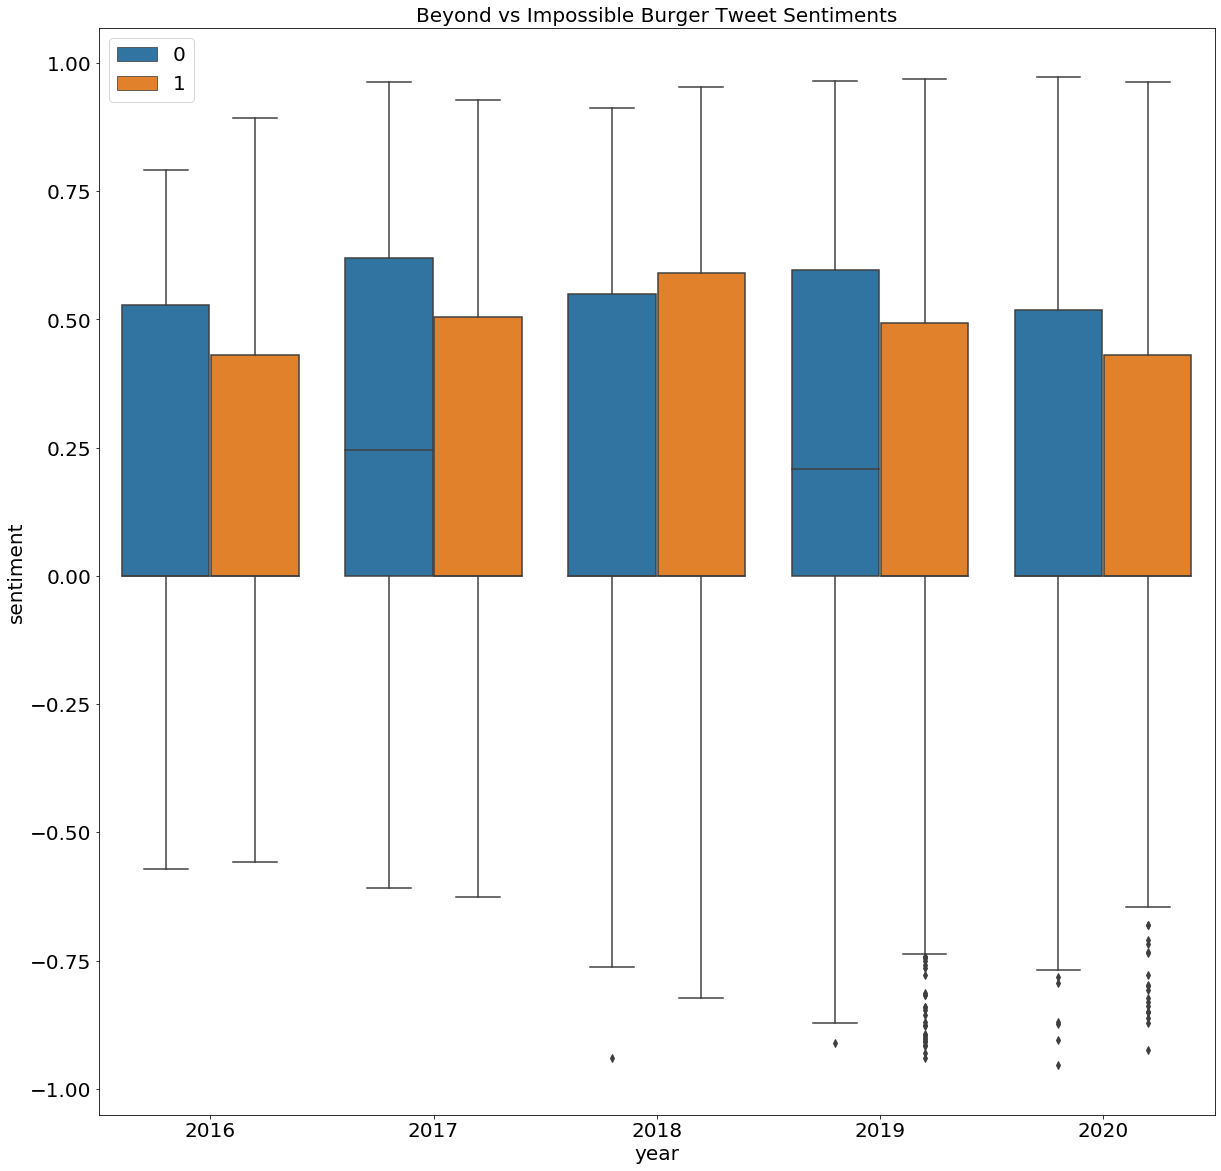

In [107]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)

sns.boxplot(x='year', y='sentiment', hue='impossible', data=df[df['year']>=2016], ax=ax);

plt.title('Beyond vs Impossible Burger Tweet Sentiments')

# Increasing size of text and ticks
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20);
ax.legend(prop={'size':20});